<a href="https://colab.research.google.com/github/HamzaNasiem/langgraph_projects/blob/main/langgraph_Tool_chatbot_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph tavily-python langchain_community langgraph-checkpoint-postgres

In [78]:
import os
from google.colab import userdata
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import MessagesState, START, StateGraph, END
from langchain_core.messages import HumanMessage, SystemMessage,AnyMessage, RemoveMessage
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph
from langgraph.checkpoint.memory import MemorySaver
from pydantic import BaseModel
from langgraph.types import Command
from typing import Literal
from psycopg_pool import ConnectionPool
from langgraph.checkpoint.postgres import PostgresSaver

In [79]:
gemini_api_key = userdata.get('GEMINI_API_KEY')
# DB_URI = userdata.get('DB_URL')
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "tool_summary_chatbot"

In [80]:
# System message
sys_msg = SystemMessage(
    content="You are a helpful assistant tasked with web searching or providing information based on user queries. If a query requires external information, use the 'web_search' tool to find the answer."
)

In [81]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", max_retries=2, api_key=gemini_api_key)
tavily_tool = TavilySearchResults(max_results=2)

In [82]:
# connection_kwargs = {"autocommit": True, "prepare_threshold": 0}
# pool = ConnectionPool(conninfo=DB_URI, max_size=20, kwargs=connection_kwargs)
# checkpointer = PostgresSaver(pool)
# checkpointer.setup()


In [83]:
def web_search(query: str) -> str:
    """Performs a web search using the Tavily API.
    Args:
        query: The search query string.
    Returns:
        str: The top search results as a formatted string.
        str: The summarized content of top search results.
        str: The URL of the top search result.
    """
    # print(f"Web search invoked with query: {query}")
    results = tavily_tool.run(query)
    # if not results:
    #     print("No results found from Tavily.")
    #     return "No results found."
    # print(f"Tavily results: {results}")
    return results


In [84]:
tools = [web_search]
llm_with_tools = llm.bind_tools(tools)

In [85]:
class State(MessagesState):
    summary: str

In [86]:
def chatbot(state: State):
    summary = state.get("summary", "")
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    response = llm_with_tools.invoke([sys_msg] + state["messages"])
    return {"messages": response}

In [88]:
def summarize_conversation(state: State):
    print(f"Messages before summarizing: {len(state['messages'])}")
    summary = state.get("summary", "")
    print(f"Existing summary: {summary}")

    # Clearer summarization prompt
    summary_message = (
        f"This is the conversation so far:\n\n{[msg.content for msg in state['messages']]}\n\n"
        "Please summarize it in 2-3 sentences for context."
    )

    # Send messages for summarization
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm_with_tools.invoke([sys_msg] + messages)

    # Debug the LLM response
    print(f"New summary: {response.content}")

    # Update the state with the new summary
    new_summary = response.content.strip()
    if new_summary:
        state["summary"] = new_summary

    # Truncate the message history
    retained_messages = state["messages"][-4:]  # Retain last 4 messages for context
    print(f"Messages after truncation: {len(retained_messages)}")
    return {"summary": new_summary, "messages": retained_messages}

In [89]:
def should_continue(state: State):
    """Return the next node to execute."""
    messages = state["messages"]
    print(f"Messages Length: {len(messages)}")  # Debugging
    if len(messages) > 6:
        return "summarize_conversation"
    return END


In [90]:
memory = MemorySaver()

builder: StateGraph = StateGraph(State)

builder.add_node("chatbot", chatbot)
builder.add_node("tools", ToolNode(tools))
builder.add_node("summarize_conversation", summarize_conversation)

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot",tools_condition)
builder.add_edge("tools", "chatbot")
builder.add_conditional_edges("chatbot",should_continue)
builder.add_edge("summarize_conversation", END)

react_graph: CompiledStateGraph = builder.compile(checkpointer=memory)


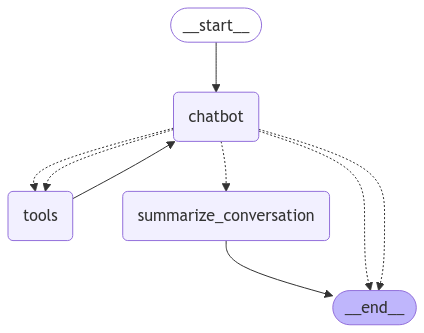

In [91]:
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [92]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi")
output = react_graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()
input_message = HumanMessage(content="who are you")
output = react_graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()
input_message = HumanMessage(content="my name is hamza")
output = react_graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()
input_message = HumanMessage(content="tell me about your self")
output = react_graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

Messages Length: 24
Messages before summarizing: 24
Existing summary: The conversation begins with introductions and requests for self-descriptions, where I identify myself as Gemini, a Google-trained large language model.  Hamza introduces himself, and the conversation concludes with a question about the weather in Karachi, which I'm unable to answer due to my lack of real-time data access.  The overall theme is establishing my identity and limitations.
New summary: The conversation begins with introductions and questions about the AI's identity (Gemini, a Google-trained large language model).  Hamza introduces himself, and the AI repeatedly explains its capabilities and limitations, including its lack of access to real-time information like weather.  Finally, the user asks for the weather in Karachi, highlighting the AI's inability to provide that data.

Messages after truncation: 4
================================== Ai Message ==================================

Hi there!  How can I

In [94]:
react_graph.get_state(config).values.get("summary","")


"The conversation is between a user named Hamza and Gemini, a Google-trained large language model.  Hamza repeatedly asks Gemini to introduce itself, receiving slightly varied but consistent responses describing Gemini's capabilities and limitations as a language model.  The conversation also includes a request for Karachi's weather, which Gemini cannot fulfill due to lack of real-time data access."